# 1. Cargar Librerias 
### Las librerias en general comprenden herramientas para el procesamiento, visualización  y paquetes de modelos de aprendizaje computacional 

In [2]:
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import io
import geopandas as gpd
import pandas as pd
import numpy as np
import pandas 
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
import rasterio
from rasterio.plot import reshape_as_image, reshape_as_raster
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score,mean_squared_error
from sklearn.model_selection import ValidationCurveDisplay
from sklearn.model_selection import learning_curve
from sklearn.model_selection import LearningCurveDisplay
from sklearn.model_selection import ShuffleSplit
from sklearn.svm import SVR
import ipywidgets as widgets
from IPython.display import display
from sklearn.linear_model import Lasso, Ridge
import plotly.io as pio
pio.renderers.default = "notebook"

# 2. Cargue del set de datos y estadisticas descriptivas
### El SHP de entrada debe ser el mismo que el generado con el script Extract_Raster_Values.py

In [3]:
# Cargar el shapefile
shapefile_path = r"C:\Users\neotr\OneDrive\Escritorio\ENTREGABLES_UNAL_HUMEDALES\Entregables_Humedal_Cordoba\SHP\Puntos_Muestreo_Reflectancia_Indices_Excel_2.shp"
gdf = gpd.read_file(shapefile_path)
gdf

# Rellenar los valores NaN con 0.3
param_cols = [
    "DQO",
    "Fosfatos",
    "Turbidez",
    "Nitratos",
    "Sulfatos",
    "ficocianin",
    "Chl",
    "CE",
    "pH"
]

gdf[param_cols] = gdf[param_cols].fillna(0.3)

## 2.1 Normalización de valores con el ln
### Bonansea M, Rodriguez MC, Pinotti L, Ferrero S (2015) Using multitemporal Landsat imagery and linear mixed models for assessing water quality parameters in Río Tercero reservoir (Argentina). Remote Sens Environ 158:28–41. https:// doi. org/ 10. 1016/j. rse.  2014. 10. 032  y  Isgró, M. A., Basallote, M. D., & Barbero, L. (2022). Unmanned Aerial System-Based Multispectral Water Quality Monitoring in the Iberian Pyrite Belt (SW Spain). Mine Water and the Environment, 41(1), 30–41. https://doi.org/10.1007/s10230-021-00837-4  Mostraron mejores correlaciones entre los valores de reflectancia extraidos cuando se transformaban los valores de los parametros de calidad de agua a valores logaritmicos

In [4]:
# Aplicar la transformación logarítmica
gdf = gdf.iloc[:65].copy()  
param_cols = [
    "DQO",
    "Fosfatos",
    "Turbidez",
    "Nitratos",
    "Sulfatos",
    "ficocianin",
    "Chl",
    "CE"
]

# Aplicar la transformación logarítmica
for col in param_cols:
    if col in gdf.columns:
        new_col = f"ln_{col}"
        gdf[new_col] = gdf[col].apply(
            lambda x: np.log(x) if pd.notnull(x) and x > 0 else 0.3
        )

# Resultados
print(" Transformación logarítmica aplicada correctamente.")
print(f" Registros retenidos: {len(gdf)}")
print(" Nuevas columnas creadas:")
print([f"ln_{c}" for c in param_cols])




 Transformación logarítmica aplicada correctamente.
 Registros retenidos: 65
 Nuevas columnas creadas:
['ln_DQO', 'ln_Fosfatos', 'ln_Turbidez', 'ln_Nitratos', 'ln_Sulfatos', 'ln_ficocianin', 'ln_Chl', 'ln_CE']


## 2.2 Estadisticas descriptivas de los datos

### Se revisaron las correlaciones de pearson encontradas entre todas las variables sujetas de estudio (Predictoras y respuesta) 

###  - Matriz de correlación para las variables respuesta transofrmadas a ln

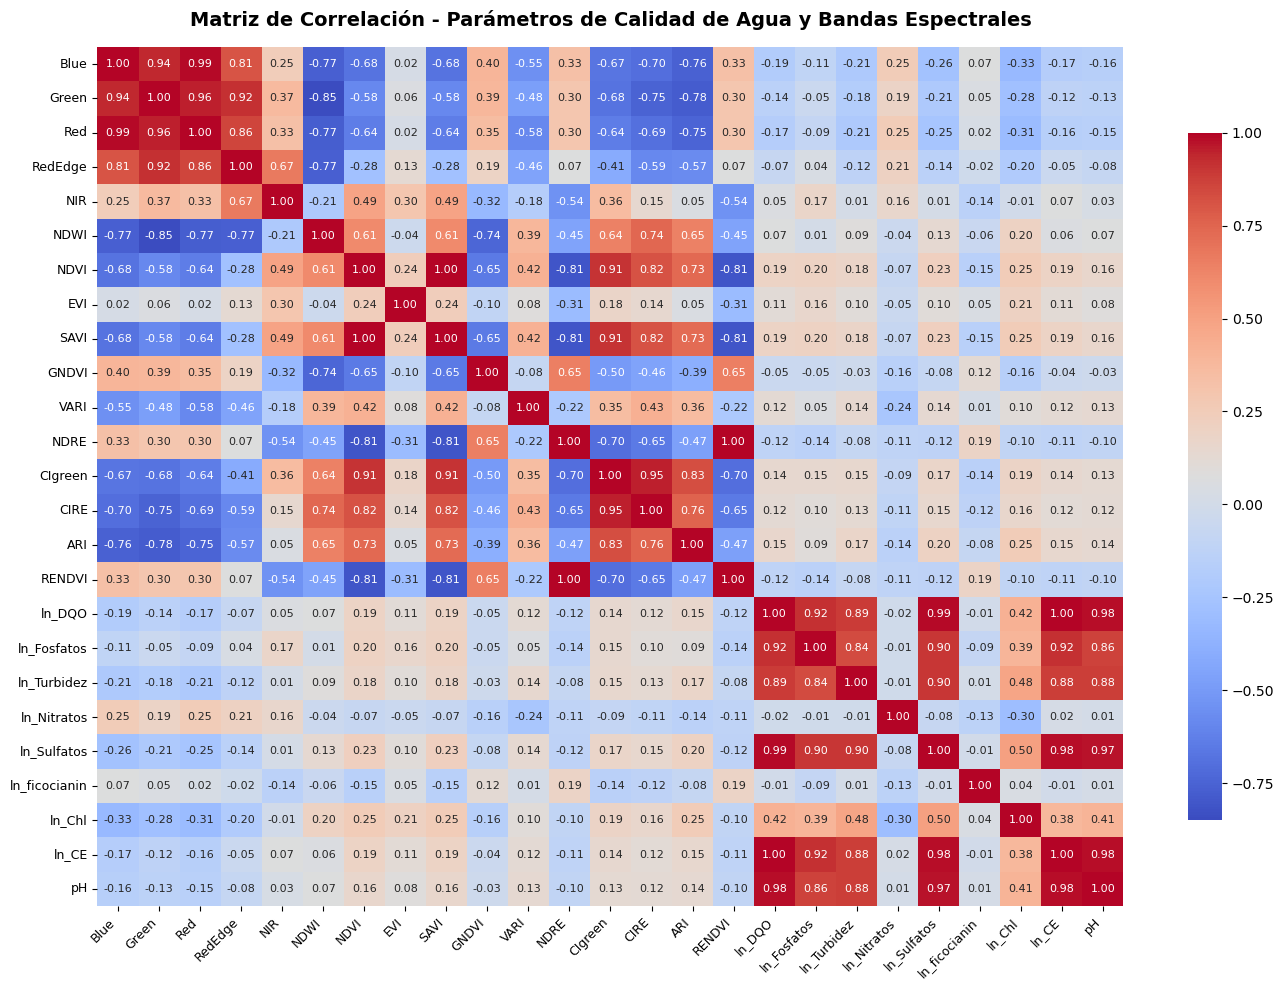

In [5]:
# Visualización de la matriz de correlación con transformación logarítmica
plt.figure(figsize=(14, 10))  

# Crear la matriz de calor
sns.heatmap(
    gdf[
        [
            "Blue","Green","Red","RedEdge","NIR",
            "NDWI","NDVI","EVI","SAVI","GNDVI","VARI",
            "NDRE","CIgreen","CIRE","ARI","RENDVI",
            "ln_DQO","ln_Fosfatos","ln_Turbidez","ln_Nitratos",
            "ln_Sulfatos","ln_ficocianin","ln_Chl","ln_CE","pH"
        ]
    ].corr(),
    annot=True,          
    cmap='coolwarm',    
    fmt='.2f',           
    annot_kws={'size': 8},  
    cbar_kws={'shrink': 0.8}  
)

# Añadir título y ajustar diseño
plt.title("Matriz de Correlación - Parámetros de Calidad de Agua y Bandas Espectrales", fontsize=14, fontweight='bold', pad=15)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()
plt.show()


### - Matriz de correlación para las variables respuesta sin transformación

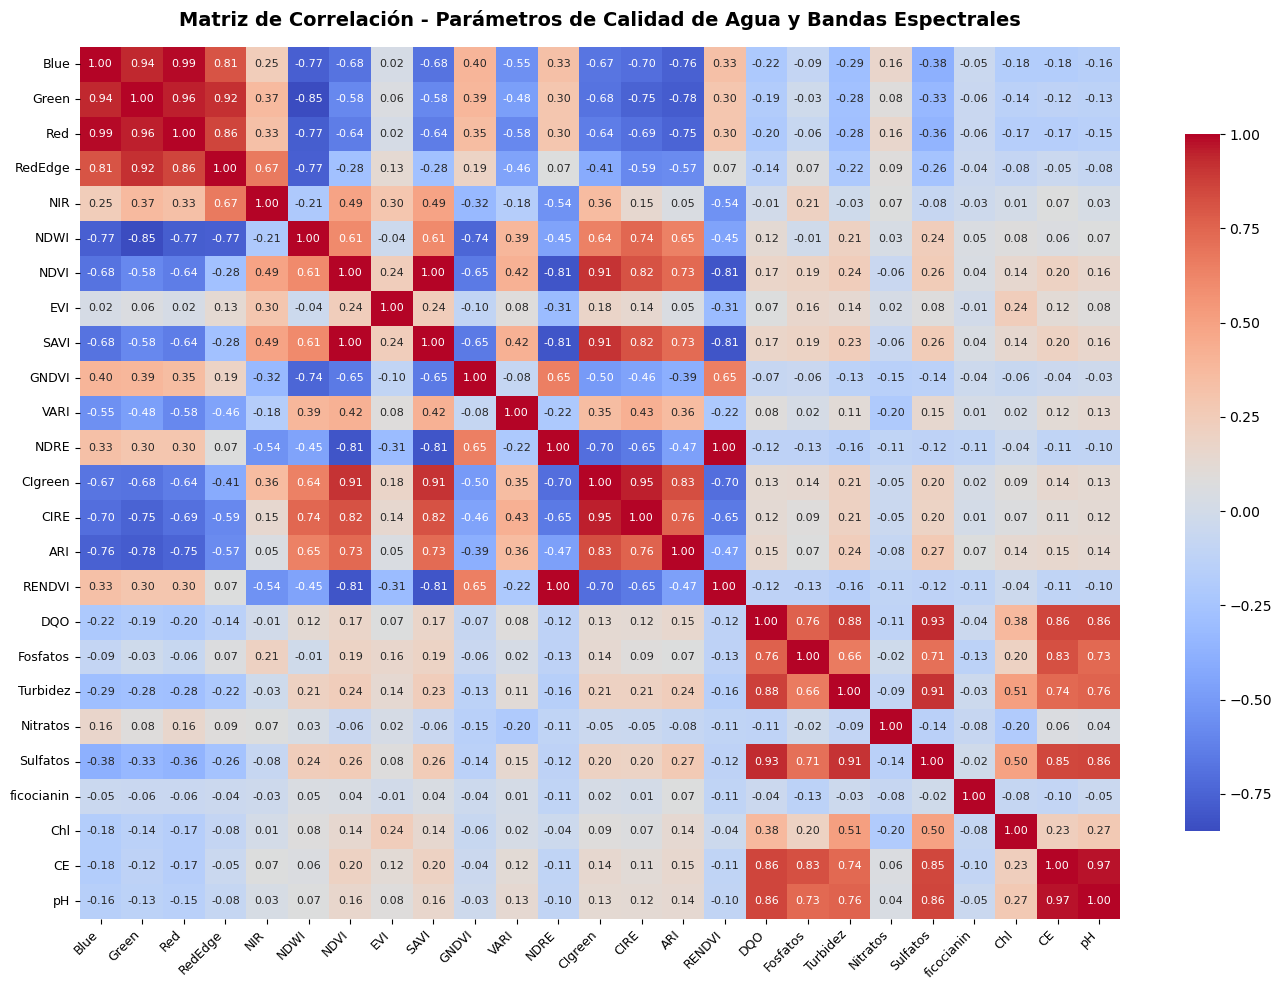

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualización de la matriz de correlación sin transformación logarítmica
plt.figure(figsize=(14, 10))  

# Crear la matriz de calor
sns.heatmap(
    gdf[
        [
            "Blue","Green","Red","RedEdge","NIR",
            "NDWI","NDVI","EVI","SAVI","GNDVI","VARI",
            "NDRE","CIgreen","CIRE","ARI","RENDVI",
            "DQO","Fosfatos","Turbidez","Nitratos",
            "Sulfatos","ficocianin","Chl","CE","pH"
        ]
    ].corr(),
    annot=True,          # Muestra los valores numéricos
    cmap='coolwarm',     # Paleta más contrastante
    fmt='.2f',           # Dos decimales
    annot_kws={'size': 8},  # Tamaño de número más pequeño
    cbar_kws={'shrink': 0.8}  # Barra lateral más compacta
)
# Añadir título y ajustar diseño
plt.title("Matriz de Correlación - Parámetros de Calidad de Agua y Bandas Espectrales", fontsize=14, fontweight='bold', pad=15)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()
plt.show()


## 2.2 Selección del parametro a analizar
### Se establecio esta sección de codigo para que el usuario pueda de forma interactiva, escoger el parametro de interes para entrenar los modelos de aprendizaje computacional y generar las predicciones sobre la ortoimágen

### - Selección del parametro de calidad de agua con transformación de ln

In [7]:
# Definir una variable para almacenar el valor seleccionado
selected_value = None  

# Funcion para actualizar la variable
def on_value_change(change):
    """Se establecio esta función para actualizar el valor seleccionado cuando el usuario interactúa con los botones de alternancia."""
    global selected_value
    selected_value = change['new']
    print(f"Seleccione el parametro de caldiad de agua de interes: {selected_value}")
# Crear los botones de alternancia
toggle_buttons = widgets.ToggleButtons(
    options=["Selecciona...", "ln_DQO","ln_Fosfatos","ln_Turbidez","ln_Nitratos",
            "ln_Sulfatos","ln_ficocianin","ln_Chl","ln_CE","pH"],
    description='Parámetro de Calidad de Agua:',
    disabled=False
)

# Vincular la función al cambio de valor
toggle_buttons.observe(on_value_change, names='value')

# Mostrar los botones
display(toggle_buttons)


ToggleButtons(description='Parámetro de Calidad de Agua:', options=('Selecciona...', 'ln_DQO', 'ln_Fosfatos', …

### - Selección del parametro de calidad de agua sin transformación

In [8]:
# Define a variable to store the selected value
selected_value = None  

# Funcion para actualizar la variable
def on_value_change(change):
    """
    Se establecio esta función para actualizar el valor seleccionado cuando el usuario interactúa con los botones de alternancia.
    """
    global selected_value
    selected_value = change['new']
    print(f"Seleccione el parametro de caldiad de agua de interes: {selected_value}")
# Crear los botones de alternancia
toggle_buttons = widgets.ToggleButtons(
    options=["Selecciona...", "DQO","Fosfatos","Turbidez","Nitratos",
            "Sulfatos","ficocianin","Chl","CE","pH"],
    description='Parámetro de Calidad de Agua:',
    disabled=False
)
# Vincular la función al cambio de valor
toggle_buttons.observe(on_value_change, names='value')

# Mostrar los botones
display(toggle_buttons)


ToggleButtons(description='Parámetro de Calidad de Agua:', options=('Selecciona...', 'DQO', 'Fosfatos', 'Turbi…

# 3. Extraer Variables predictoras y variables respuesta para los modelos de aprendizaje computacional
### En esta sección de codigo se separan las variables predictoras y las variables respuesta para entrenar los modelos de aprendizaje computacional

### -  Separación de variables predictoras y respuesta con transformación ln

In [9]:
# Definir características y variable objetivo
X= gdf.drop(columns = ["Name","ID_Muestra","ln_DQO","ln_Fosfatos","ln_Turbidez","ln_Nitratos",
            "ln_Sulfatos","ln_ficocianin","ln_Chl","ln_CE","pH","DQO","Fosfatos","Turbidez","Nitratos",
            "Sulfatos","ficocianin","Chl","CE","Pan","geometry"])
y = gdf[selected_value]
X




,Blue,Green,Red,RedEdge,NIR,NDVI,NDWI,EVI,SAVI,GNDVI,VARI,NDRE,CIgreen,CIRE,ARI,RENDVI
0,331.578512,715.958678,294.842975,1077.388430,1499.157025,0.671318,29.240503,3.977107,1.006696,0.353480,0.620842,0.163805,1.094836,0.393322,0.000468,0.163805
1,384.785124,657.983471,322.669421,826.066116,736.652893,0.390807,46.951288,-1.893458,0.585934,0.056296,0.563630,41.536912,0.119913,-0.106933,0.000308,41.536912
2,429.991736,738.586777,362.702479,892.727273,726.082645,0.333632,14.221407,-2.232676,0.500218,30.543692,0.561063,40.411436,-0.016434,-0.185348,0.000233,40.411436
3,395.925620,686.636364,344.537190,848.512397,769.198347,0.380933,43.820481,-25.859135,0.571144,1.232330,0.539585,39.859483,0.120916,-0.092422,0.000277,39.859483
4,405.710744,696.760331,339.396694,857.181818,869.000000,0.438305,41.763944,26.728346,0.657186,0.109850,0.568049,14.358109,0.247779,0.015354,0.000268,14.358109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,475.652893,765.429752,402.793388,888.859504,915.619835,0.388848,38.916290,-13.393249,0.583050,0.089108,0.524475,9.704247,0.196628,0.031230,0.000181,9.704247
61,525.305785,823.636364,445.504132,971.355372,942.776860,0.358106,37.057542,-5.225563,0.536965,0.067183,0.509402,24.031107,0.145115,-0.028037,0.000184,24.031107
62,566.214876,989.991736,509.628099,1102.570248,872.462810,0.262410,0.063339,-3.819904,0.393472,35.138072,0.515185,33.081715,-0.118479,-0.207874,0.000103,33.081715
63,476.611570,834.404959,410.421488,941.801653,885.289256,0.366446,35.230348,-3.049757,0.549457,2.893053,0.552679,31.941378,0.061582,-0.058774,0.000136,31.941378


### -  Separación de variables predictoras y respuesta sin transformación

In [ ]:
# Definir características y variable objetivo
X= gdf.drop(columns = ["Name","ID_Muestra","DQO","Fosfatos","Turbidez","Nitratos",
            "Sulfatos","ficocianin","Chl","CE","pH","DQO","Fosfatos","Turbidez","Nitratos",
            "Sulfatos","ficocianin","Chl","CE","Pan","geometry"])
y = gdf[selected_value]
X


,Blue,Green,Red,RedEdge,NIR,NDVI,NDWI,EVI,SAVI,GNDVI,VARI,NDRE,CIgreen,CIRE,ARI,RENDVI
0,331.578512,715.958678,294.842975,1077.388430,1499.157025,0.671318,29.240503,3.977107,1.006696,0.353480,0.620842,0.163805,1.094836,0.393322,0.000468,0.163805
1,384.785124,657.983471,322.669421,826.066116,736.652893,0.390807,46.951288,-1.893458,0.585934,0.056296,0.563630,41.536912,0.119913,-0.106933,0.000308,41.536912
2,429.991736,738.586777,362.702479,892.727273,726.082645,0.333632,14.221407,-2.232676,0.500218,30.543692,0.561063,40.411436,-0.016434,-0.185348,0.000233,40.411436
3,395.925620,686.636364,344.537190,848.512397,769.198347,0.380933,43.820481,-25.859135,0.571144,1.232330,0.539585,39.859483,0.120916,-0.092422,0.000277,39.859483
4,405.710744,696.760331,339.396694,857.181818,869.000000,0.438305,41.763944,26.728346,0.657186,0.109850,0.568049,14.358109,0.247779,0.015354,0.000268,14.358109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,380.214876,656.404959,316.809917,764.925620,683.181818,0.366323,40.725208,-3.800445,0.549210,7.394205,0.573732,44.865053,0.041469,-0.105757,0.000215,44.865053
74,384.661157,739.884298,328.661157,978.537190,1324.148760,0.602342,31.479235,7.082722,0.903239,0.283017,0.602135,0.150165,0.790772,0.354483,0.000329,0.150165
75,352.545455,628.206612,297.636364,743.917355,683.471074,0.393168,49.082624,-4.004148,0.589452,0.901967,0.577544,43.174417,0.088283,-0.079970,0.000246,43.174417
76,348.297521,616.438017,285.074380,785.355372,799.727273,0.474269,46.168200,2.771053,0.711076,0.129125,0.599934,13.407390,0.297947,0.019350,0.000348,13.407390


# 3.1 Separar variables de entrenamiento y de validación del modelo
 ## Se generó una división de las muestras para entrenar los modelos y para validarlos, dejando una proporción del 85% del total de muestras para entrenar los modelos y un 15% para validarlos

In [10]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1)
X_train

,Blue,Green,Red,RedEdge,NIR,NDVI,NDWI,EVI,SAVI,GNDVI,VARI,NDRE,CIgreen,CIRE,ARI,RENDVI
36,497.289256,878.388430,454.743802,1167.181818,1401.694215,0.509904,28.524325,4.716618,0.764651,0.229296,0.507469,0.091255,0.596454,0.202044,0.000281,0.091255
39,488.157025,862.115702,450.719008,998.157025,1048.355372,0.398641,34.215071,-2.975567,0.597762,0.097317,0.499567,2.919475,0.216596,0.051425,0.000157,2.919475
63,476.611570,834.404959,410.421488,941.801653,885.289256,0.366446,35.230348,-3.049757,0.549457,2.893053,0.552679,31.941378,0.061582,-0.058774,0.000136,31.941378
35,490.157025,876.157025,443.661157,1074.206612,1147.636364,0.442274,32.284453,1.229037,0.663201,0.133489,0.522702,4.206506,0.310443,0.070119,0.000209,4.206506
27,491.223140,803.710744,437.966942,922.008264,972.619835,0.376640,36.254496,4.557285,0.564760,0.773653,0.489380,12.181709,0.210047,0.054592,0.000156,12.181709
58,525.851240,816.603306,460.132231,985.752066,1029.512397,0.382156,35.398317,-4.615587,0.573042,0.115116,0.475751,5.630346,0.261120,0.045778,0.000209,5.630346
50,460.958678,782.041322,377.619835,887.115702,838.454545,0.379045,37.365173,0.543530,0.568333,2.767246,0.580145,34.212396,0.073056,-0.053553,0.000151,34.212396
3,395.925620,686.636364,344.537190,848.512397,769.198347,0.380933,43.820481,-25.859135,0.571144,1.232330,0.539585,39.859483,0.120916,-0.092422,0.000277,39.859483
31,509.057851,891.884298,463.396694,1300.429752,1825.429752,0.595101,23.783505,4.478911,0.892457,0.343596,0.506779,0.168023,1.048778,0.404947,0.000353,0.168023
24,413.347107,733.446281,363.504132,906.190083,973.685950,0.456245,38.269681,-10.448202,0.684112,0.140472,0.542349,4.374325,0.328636,0.076383,0.000259,4.374325


# 4. Entrenar el modelos de aprendizaje computacional

### Con cada modelo de aprendizaje computacional se probaron diferentes configuraciones de hiperparametros iterando diferentes combinaciones de los mismos, escogiendo el mejor para cada parametros de calidad de agua escogido

### 4.1 SVR (Support Vector Regressor)

In [11]:
# Hiperparámetros para SVR
param_grid_svr = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 1],
    'kernel': ['rbf', 'linear', 'poly']
}
# Entrenar SVR con GridSearchCV
svr = SVR()
svr_cv = GridSearchCV(svr, param_grid_svr, cv=5, n_jobs=-1)
svr_cv.fit(X_train, y_train)
best_params_svr = svr_cv.best_params_
print("Mejores Hiperparametros para SVR :", best_params_svr)
optimized_svr = SVR(**best_params_svr)
optimized_svr.fit(X_train, y_train)
optimized_svr


Mejores Hiperparametros para SVR : {'C': 0.1, 'epsilon': 0.01, 'kernel': 'rbf'}


,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,tol,0.001
,C,0.1
,epsilon,0.01
,shrinking,True
,cache_size,200
,verbose,False
,max_iter,-1


### 4.2 XGBoost (Gradient Boost Regressor)

In [12]:
# Definir hiperparámetros para Gradient Boosting Regressor
param_grid_gbr = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3, 4]
}
# Entrenar Gradient Boosting Regressor con GridSearchCV
gbr = GradientBoostingRegressor(random_state=13)
gbr_cv = GridSearchCV(estimator=gbr, param_grid=param_grid_gbr, cv=3, scoring='neg_mean_squared_error',n_jobs=-1)
gbr_cv.fit(X_train, y_train)
best_params_gbr = gbr_cv.best_params_
print("Best GBR Parameters:", best_params_gbr)
optimized_gbr = GradientBoostingRegressor(random_state=13, **best_params_gbr)
optimized_gbr.fit(X_train, y_train)
optimized_gbr

Best GBR Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}


,loss,'squared_error'
,learning_rate,0.01
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,4
,min_weight_fraction_leaf,0.0
,max_depth,5
,min_impurity_decrease,0.0
,init,None


### 4.3 RFR (Random Forest Regressor) 

In [13]:
# Definir hiperparámetros para Random Forest Regressor
param_grid_rfr = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4]
}
# Entrenar Random Forest Regressor con GridSearchCV
rfr = RandomForestRegressor(random_state=13)
rfr_cv = GridSearchCV(estimator=rfr, param_grid=param_grid_rfr, cv=3, scoring='neg_mean_squared_error',n_jobs=-1)
rfr_cv.fit(X_train, y_train)
best_params_rfr = rfr_cv.best_params_
print("Best RFR Parameters:", best_params_rfr)
optimized_rfr = RandomForestRegressor(random_state=13, **best_params_rfr,n_jobs=-1)
optimized_rfr.fit(X_train, y_train)
optimized_rfr

Best RFR Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}


,n_estimators,300
,criterion,'squared_error'
,max_depth,10
,min_samples_split,10
,min_samples_leaf,4
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


# 5 Validación de los modelos

### Para cada modelo se establecido el valor de R2, MAE y RMSe, siendo el RMSe el parametro de mayor interes para saber el error real del modelo en la estimación de los parametros de calidad de agua. Adicionalmente se generó una gráfica de importancia de variables para XGBoost y RFR ya que su arquitectura permite establecer estos valore. Esto permite saber que variables predictoras son las que mayor aportan a la estimación del parametro de calidad de agua escogido 

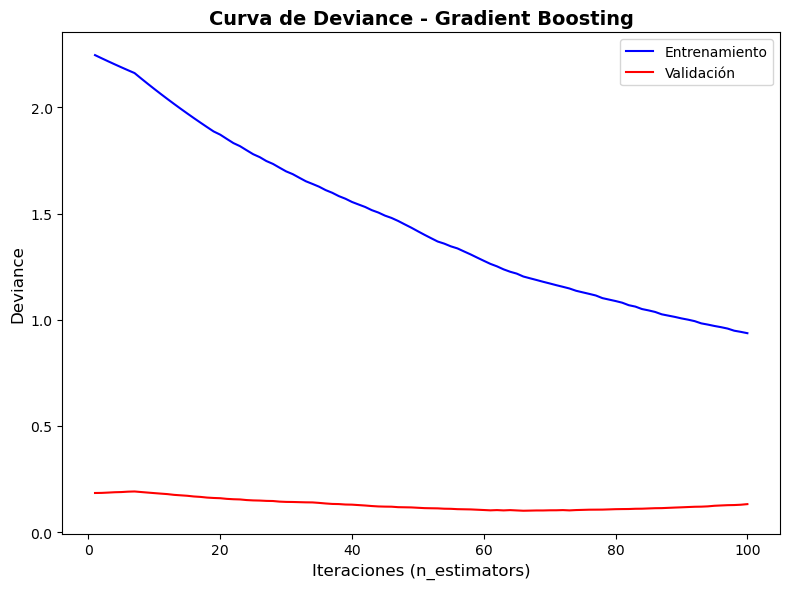

Gradient Boosting:
MAE  = 0.2504
RMSE = 0.3630
R²   = -8.1012



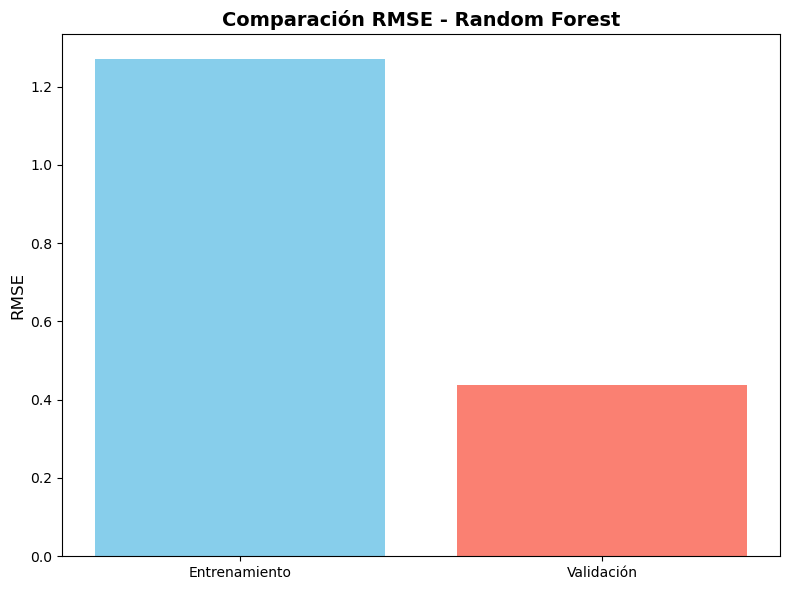

 Random Forest:
MAE  = 0.2796
RMSE = 0.4372
R²   = -12.2026



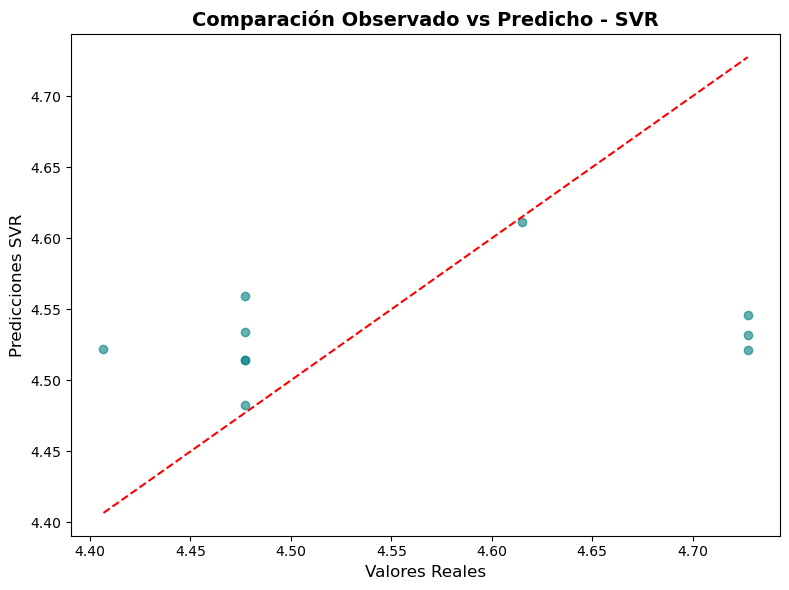

 Support Vector Regressor:
MAE  = 0.0920
RMSE = 0.1181
R²   = 0.0371



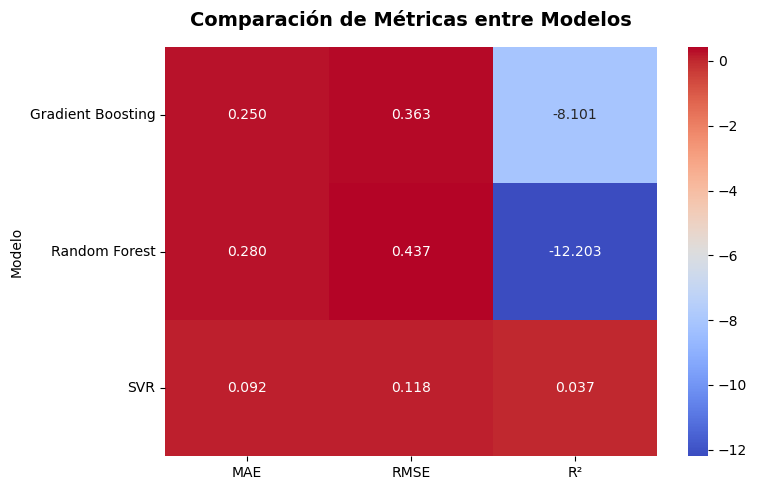

C:\Users\neotr\AppData\Local\Temp\ipykernel_14536\2809593389.py:115: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


C:\Users\neotr\AppData\Local\Temp\ipykernel_14536\2809593389.py:121: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




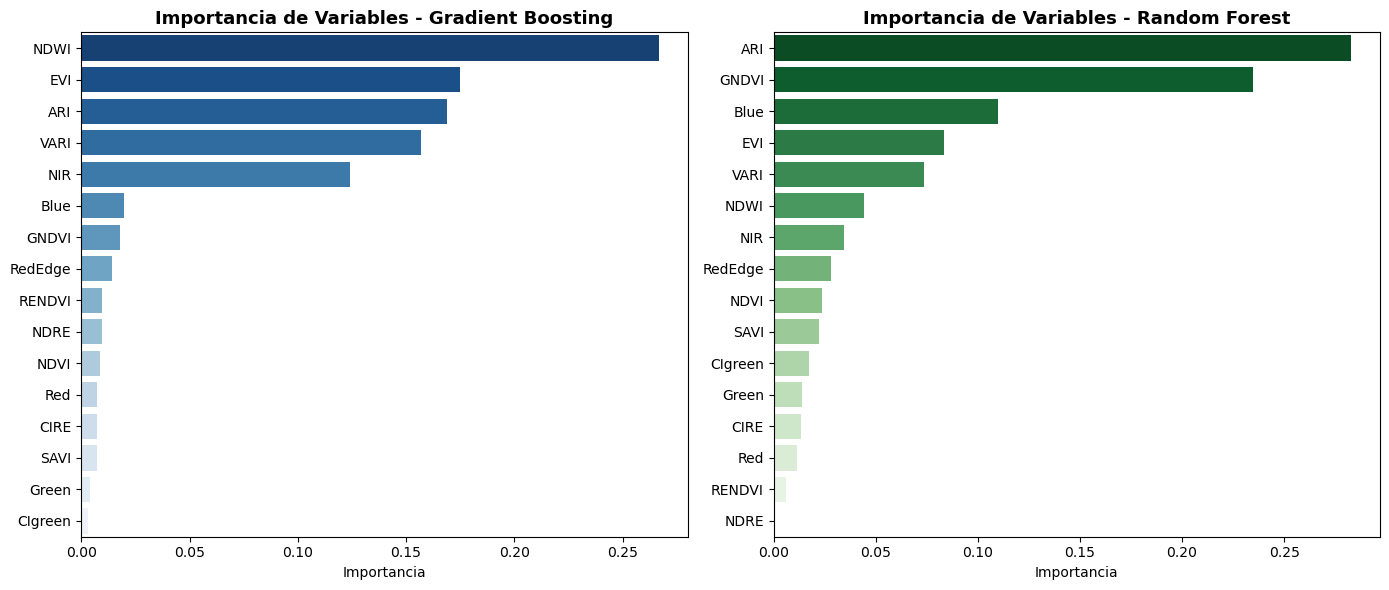

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#Modelo : SUPPORTED VECTOR REGRESSOR

n_estimators = best_params_gbr['n_estimators']
test_score = np.zeros((n_estimators,), dtype=np.float64)

for i, y_pred in enumerate(optimized_gbr.staged_predict(X_test)):
    if i < n_estimators:
        test_score[i] = mean_squared_error(y_test, y_pred)

plt.figure(figsize=(8, 6))
plt.title("Curva de Deviance - Gradient Boosting", fontsize=14, fontweight="bold")
plt.plot(np.arange(n_estimators) + 1, optimized_gbr.train_score_, "b-", label="Entrenamiento")
plt.plot(np.arange(n_estimators) + 1, test_score, "r-", label="Validación")
plt.legend()
plt.xlabel("Iteraciones (n_estimators)", fontsize=12)
plt.ylabel("Deviance", fontsize=12)
plt.tight_layout()
plt.show()

y_pred_gbr = optimized_gbr.predict(X_test)
mae_gbr = mean_absolute_error(y_test, y_pred_gbr)
rmse_gbr = np.sqrt(mean_squared_error(y_test, y_pred_gbr))
r2_gbr = r2_score(y_test, y_pred_gbr)

print(f"Gradient Boosting:")
print(f"MAE  = {mae_gbr:.4f}")
print(f"RMSE = {rmse_gbr:.4f}")
print(f"R²   = {r2_gbr:.4f}\n")

# === Importancia de variables ===
feature_names = ["Blue","Green","Red","RedEdge","NIR","NDWI","NDVI","EVI",
                 "SAVI","GNDVI","VARI","NDRE","CIgreen","CIRE","ARI","RENDVI"]


feature_names = X_train.columns
importance_gbr = optimized_gbr.feature_importances_
feature_importance_gbr = pd.DataFrame({
    'Variable': feature_names,
    'Importancia': importance_gbr
}).sort_values(by='Importancia', ascending=False)

# Modelo : RANDOM FOREST REGRESSOR
y_pred_rf = optimized_rfr.predict(X_test)
y_train_rf = optimized_rfr.predict(X_train)

rmse_rf_test = np.sqrt(mean_squared_error(y_test, y_pred_rf))
rmse_rf_train = np.sqrt(mean_squared_error(y_train, y_train_rf))

plt.figure(figsize=(8, 6))
plt.title("Comparación RMSE - Random Forest", fontsize=14, fontweight="bold")
plt.bar(["Entrenamiento", "Validación"], [rmse_rf_train, rmse_rf_test], color=["skyblue", "salmon"])
plt.ylabel("RMSE", fontsize=12)
plt.tight_layout()
plt.show()

mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f" Random Forest:")
print(f"MAE  = {mae_rf:.4f}")
print(f"RMSE = {rmse_rf_test:.4f}")
print(f"R²   = {r2_rf:.4f}\n")

# === Importancia de variables ===
importance_rf = optimized_rfr.feature_importances_
feature_importance_rf = pd.DataFrame({
    'Variable': feature_names,
    'Importancia': importance_rf
}).sort_values(by='Importancia', ascending=False)

# Modelo: SUPPORT VECTOR REGRESSOR
y_pred_svr = optimized_svr.predict(X_test)
mae_svr = mean_absolute_error(y_test, y_pred_svr)
rmse_svr = np.sqrt(mean_squared_error(y_test, y_pred_svr))
r2_svr = r2_score(y_test, y_pred_svr)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_svr, color="teal", alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("Valores Reales", fontsize=12)
plt.ylabel("Predicciones SVR", fontsize=12)
plt.title("Comparación Observado vs Predicho - SVR", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

print(f" Support Vector Regressor:")
print(f"MAE  = {mae_svr:.4f}")
print(f"RMSE = {rmse_svr:.4f}")
print(f"R²   = {r2_svr:.4f}\n")

# Mapa de calor comparativo de métricas
metricas_df = pd.DataFrame({
    'Modelo': ['Gradient Boosting', 'Random Forest', 'SVR'],
    'MAE': [mae_gbr, mae_rf, mae_svr],
    'RMSE': [rmse_gbr, rmse_rf_test, rmse_svr],
    'R²': [r2_gbr, r2_rf, r2_svr]
}).set_index('Modelo')

plt.figure(figsize=(8, 5))
sns.heatmap(metricas_df, annot=True, fmt=".3f", cmap='coolwarm', annot_kws={'size': 10})
plt.title("Comparación de Métricas entre Modelos", fontsize=14, fontweight='bold', pad=15)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Importancia de variables para ambos modelos
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.barplot(data=feature_importance_gbr, x='Importancia', y='Variable',
            ax=axes[0], palette='Blues_r')
axes[0].set_title("Importancia de Variables - Gradient Boosting", fontsize=13, fontweight='bold')
axes[0].set_xlabel("Importancia")
axes[0].set_ylabel("")

sns.barplot(data=feature_importance_rf, x='Importancia', y='Variable',
            ax=axes[1], palette='Greens_r')
axes[1].set_title("Importancia de Variables - Random Forest", fontsize=13, fontweight='bold')
axes[1].set_xlabel("Importancia")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()


# 6. Predicción sobre imagen multiespectral
### Con los modelos entrenados y validados, se desarrollo la sección para leer la ortoimágen multiespectral, generada con el sensor Micasense RedEdge P, calculo de indices espectrales y generación de la vectorial de estimación final

In [15]:
# Preparación de datos raster para predicción
raster_path = r"C:\Users\neotr\OneDrive\Escritorio\ENTREGABLES_UNAL_HUMEDALES\Entregables_Humedal_Cordoba\Orto_Clip\HC_Clip.tif"
with rasterio.open(raster_path) as src:
    data = src.read()   # (n_bands, H, W)
    profile = src.profile
print(f"Imagen original: {data.shape[0]} bandas → {data.shape[1]}x{data.shape[2]} pixeles")
# Orden RedEdge-P: 0Blue, 1Green, 2Pan, 3Red, 4RedEdge, 5NIR
bandas_filtradas = np.delete(data, 2, axis=0)
print("Bandas utilizadas (sin PAN):",
      bandas_filtradas.shape[0], "(Blue, Green, Red, RedEdge, NIR)")
blue     = bandas_filtradas[0]
green    = bandas_filtradas[1]
red      = bandas_filtradas[2]
rededge  = bandas_filtradas[3]
nir      = bandas_filtradas[4]
def safe_div(a, b):
    return np.where(b != 0, a / b, 0)
#  Índices básicos
ndvi    = safe_div((nir - red), (nir + red))
ndwi    = safe_div((green - nir), (green + nir))
gndvi   = safe_div((nir - green), (nir + green))
ndre    = safe_div((nir - rededge), (nir + rededge))
vari    = safe_div((green - red), (green + red - blue))
rendvi  = safe_div((nir - rededge), (nir + red))
cigre   = safe_div(nir, green)
cire    = safe_div(nir, rededge)
ari     = safe_div(1, green**2)  # ARI simplificado
evi = 2.5 * (nir - red) / (nir + 6*red - 7.5*blue + 1)
savi = 1.5 * (nir - red) / (nir + red + 0.5)
indices = [
    ndvi, ndwi, evi, savi, gndvi, vari, ndre,
    cigre, cire, ari, rendvi
]
stack_final = np.vstack(
    [bandas_filtradas] + [idx[np.newaxis, :, :] for idx in indices]
)
# Reshape para modelo ML
new_band_count = stack_final.shape[0]
print(f"Stack final: {new_band_count} bandas")
H, W = stack_final.shape[1:]
# Reshape para predicción
data_for_model = stack_final.reshape(new_band_count, -1).T
# Limpieza y preparación de datos
data_clean = data_for_model.copy()
index_cols = np.arange(5, data_clean.shape[1])
data_clean[:, index_cols] = np.clip(data_clean[:, index_cols], -5, 5)
data_clean = np.nan_to_num(data_clean, nan=0.0, posinf=0.0, neginf=0.0)
print("Datos listos para modelo:", data_clean.shape)


Imagen original: 6 bandas → 9071x9487 pixeles
Bandas utilizadas (sin PAN): 5 (Blue, Green, Red, RedEdge, NIR)


C:\Users\neotr\AppData\Local\Temp\ipykernel_14536\3568045648.py:17: RuntimeWarning:

invalid value encountered in divide

C:\Users\neotr\AppData\Local\Temp\ipykernel_14536\3568045648.py:17: RuntimeWarning:

divide by zero encountered in divide

C:\Users\neotr\AppData\Local\Temp\ipykernel_14536\3568045648.py:28: RuntimeWarning:

divide by zero encountered in divide



Stack final: 16 bandas
Datos listos para modelo: (86056577, 16)


# 6.1 Estimación del parametro de calidad de agua escogido

### A partir de la generación de la matriz vectorial de la imágen multiespectral e indices espectrales se estiman los valores de calidad de agua para cada pixel de la imágen con los 3 modelos de aprendizaje computacional, esto genera una matriz bidimensional que contiene los valores del parametro de calidad de agua escogido

In [16]:
predicted_image_svr = optimized_svr.predict(data_clean)
predicted_image_rfr = optimized_rfr.predict(data_clean)
predicted_image_gbr = optimized_gbr.predict(data_clean)

c:\env\analisis_datos_un\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but SVR was fitted with feature names

c:\env\analisis_datos_un\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names

c:\env\analisis_datos_un\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names



# 7. Reconstrucción de la imagen original 
### Esta sección de codigo, reconstruye la matriz de valores de calidad de agua a una imagen a partir de los valores de ancho, largo y sistema de cooredanas originales de la ortoimágen para poderla leer en cualquier software GIS, adicionalmente se dejó una sección de codigo comentariado para devolver los valores de calidad de agua a su escala original en caso de que se alla aplicado la transformación

In [20]:
# Reshape a la forma original de la imagen
image_svr_log = predicted_image_svr.reshape(H, W)
image_rfr_log = predicted_image_rfr.reshape(H, W)
image_gbr_log = predicted_image_gbr.reshape(H, W)

# --- Convertir de logaritmo natural a escala original ---

image_svr = np.exp(image_svr_log)
image_rfr = np.exp(image_rfr_log)
image_gbr = np.exp(image_gbr_log)

# image_svr = image_svr_log
# image_gbr = image_gbr_log
# image_rfr = image_rfr_log

# 8. Guardar Imagen Generada
### Finalmente se exportan las estimaciones del parametro de calidad de agua medido, cortando el raster con el area efectiva de agua que existe sobre el humedal.  

Reproyectando shapefile para que coincida con el CRS del raster...
Imagen exportada y recortada: C:\Users\neotr\OneDrive\Escritorio\ENTREGABLES_UNAL_HUMEDALES\Salidas_Modelos\ln_DQO\ln_DQO_SVR.tif
Imagen exportada y recortada: C:\Users\neotr\OneDrive\Escritorio\ENTREGABLES_UNAL_HUMEDALES\Salidas_Modelos\ln_DQO\ln_DQO_RFR.tif
Imagen exportada y recortada: C:\Users\neotr\OneDrive\Escritorio\ENTREGABLES_UNAL_HUMEDALES\Salidas_Modelos\ln_DQO\ln_DQO_GBR.tif

Todas las imágenes fueron recortadas y guardadas correctamente.


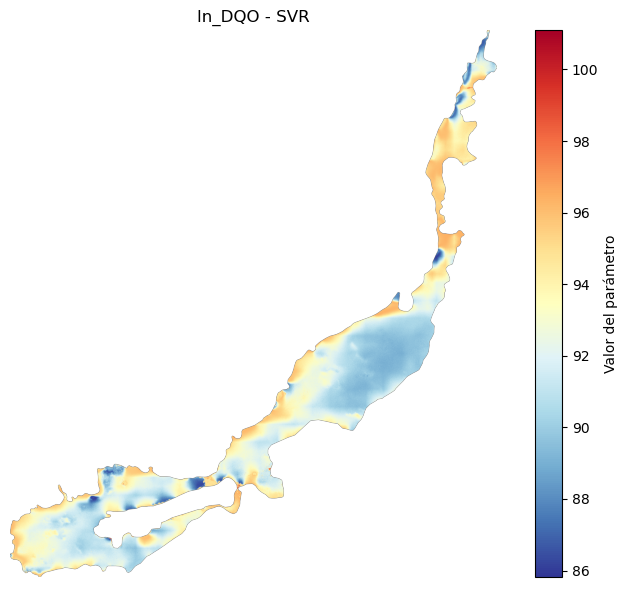

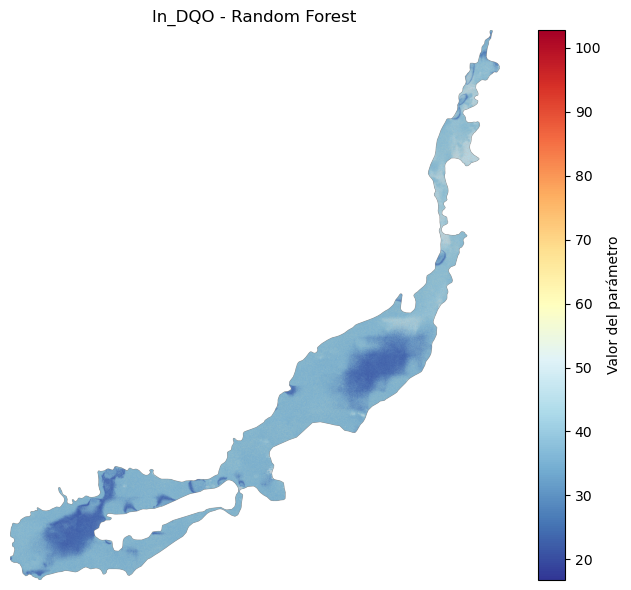

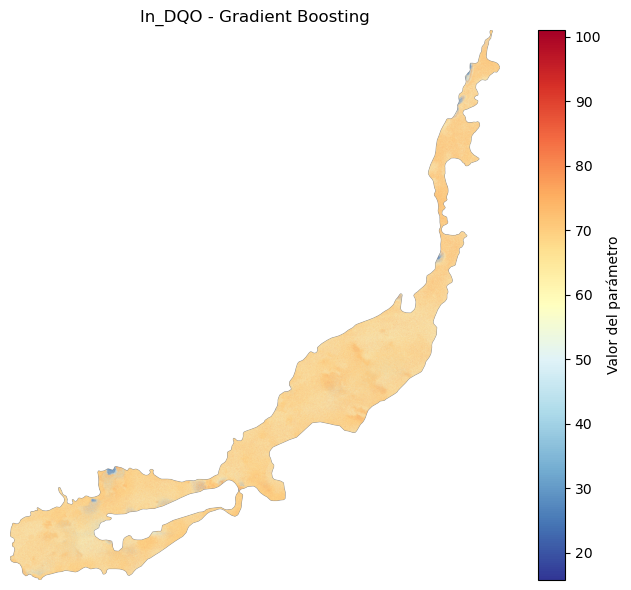

In [21]:
import os
import tempfile
import numpy as np
import rasterio
from rasterio.mask import mask
import geopandas as gpd
os.environ["GDAL_MEM_ENABLE_OPEN"] = "YES"

# Ruta de salida y shapefile para cortar los resultados al espejo de agua
out_path = r"C:\Users\neotr\OneDrive\Escritorio\ENTREGABLES_UNAL_HUMEDALES\Salidas_Modelos"
shapefile_path = r"C:\Users\neotr\OneDrive\Escritorio\ENTREGABLES_UNAL_HUMEDALES\Limite_Humedal\Limite_Espejo_Agua.shp"

# Crear carpeta base
os.makedirs(out_path, exist_ok=True)

# Crear subcarpeta según el parámetro
param_dir = os.path.join(out_path, selected_value)
os.makedirs(param_dir, exist_ok=True)

# Definir rutas de salida
output_path_SVR = os.path.join(param_dir, f"{selected_value}_SVR.tif")
output_path_RFR = os.path.join(param_dir, f"{selected_value}_RFR.tif")
output_path_GBR = os.path.join(param_dir, f"{selected_value}_GBR.tif")

# Cargar shapefile
gdf = gpd.read_file(shapefile_path)

# Asegurar que el CRS coincida con el del raster
if gdf.crs != profile["crs"]:
    print("Reproyectando shapefile para que coincida con el CRS del raster...")
    gdf = gdf.to_crs(profile["crs"])

geoms = gdf.geometry.values  # lista de geometrías


# Función para recortar y exportar el raster 
def exportar_recortado(image, profile, output_path, geoms):
    """Recorta una imagen con shapefile y la exporta a GeoTIFF."""
    import tempfile
    import os
    import numpy as np
    import rasterio
    from rasterio.mask import mask

    # Asegurar que la imagen tenga la forma correcta (1, alto, ancho)
    if image.ndim == 2:
        image = np.expand_dims(image, axis=0)
    elif image.ndim == 3 and image.shape[0] != 1:
        raise ValueError(f"La imagen tiene {image.shape[0]} bandas. Debe tener solo una.")

    # Crear archivo temporal seguro
    with tempfile.NamedTemporaryFile(suffix=".tif", delete=False) as tmpfile:
        temp_path = tmpfile.name

    # Guardar temporalmente la imagen
    with rasterio.open(temp_path, "w", **profile) as tmp:
        tmp.write(image.astype(rasterio.float32))

    # Reabrir desde disco y aplicar recorte
    with rasterio.open(temp_path) as dataset:
        clipped, transform = mask(dataset, geoms, crop=True)
        clipped_profile = dataset.profile.copy()
        clipped_profile.update({
            "height": clipped.shape[1],
            "width": clipped.shape[2],
            "transform": transform
        })

    # Guardar raster recortado
    with rasterio.open(output_path, "w", **clipped_profile) as dst:
        dst.write(clipped.astype(rasterio.float32))

    print(f"Imagen exportada y recortada: {output_path}")

    # Eliminar archivo temporal
    os.remove(temp_path)

# Exportar los resultados de los tres modelos. 
profile.update(dtype=rasterio.float32, count=1)

exportar_recortado(image_svr, profile, output_path_SVR, geoms)
exportar_recortado(image_rfr, profile, output_path_RFR, geoms)
exportar_recortado(image_gbr, profile, output_path_GBR, geoms)

print("\nTodas las imágenes fueron recortadas y guardadas correctamente.")

def mostrar_raster(path, titulo, cmap="RdYlBu_r"):
    """
    Muestra un raster usando una paleta azul (bajo) a rojo (alto)
    """
    with rasterio.open(path) as src:
        data = src.read(1).astype(float)
        nodata = src.nodata

    # Enmascarar NoData
    if nodata is not None:
        data = np.ma.masked_equal(data, nodata)

    plt.figure(figsize=(8, 6))
    im = plt.imshow(data, cmap=cmap)
    plt.colorbar(im, label="Valor del parámetro")
    plt.title(titulo)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

mostrar_raster(output_path_SVR, f"{selected_value} - SVR")
mostrar_raster(output_path_RFR, f"{selected_value} - Random Forest")
mostrar_raster(output_path_GBR, f"{selected_value} - Gradient Boosting")

